In [11]:
from dsets import lvis_dataset,transformations
from torchvision import transforms


annotations="datasets/lvis/data"
root=""
inp_dim=416

lv = lvis_dataset.LVISDetection(root = '../../../datasets/coco/images',
                    annFile = '../../../datasets/lvis/data/lvis_val_100.json',
                    subset=1,
                    transform=transforms.Compose([
                        transformations.ResizeToTensor(inp_dim)
                                           ]))

In [4]:
import torch
state_dict = torch.load('output/coco_baseline/checkpoints/last.tar')['model_state_dict']
# create new OrderedDict that does not contain `module.`
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v
# load params
torch.save(new_state_dict, "output/coco_baseline/checkpoints/last1.tar")

## Train

In [8]:
from torch.utils.data import DataLoader
from utilities import helper
from torch import optim
import torch
from nets.yolohead import YoloHead
from nets.yolo_loss import YOLOLoss
import sys
from dsets import coco_dataset,transformations
from torchvision import transforms
from utilities import helper
import torch
from apex import amp
from torch import nn
import numpy as np
from torchvision.ops import boxes

annotations="../../../datasets/coco/annotations/instances_train2017.json"
root='../../../datasets/coco/images'
inp_dim=416

cc = coco_dataset.CocoDetection(root = root,
                    annFile = annotations,
                    subset=1,
                    transform=transforms.Compose([
                        transformations.ResizeToTensor(inp_dim),
                        transformations.COCO91_80()
                                           ]))

test_dataloader=DataLoader(cc,batch_size=4,shuffle=False, num_workers=0,collate_fn=helper.collate_fn)
test_dataloader.dset_name='coco'

config = {"backbone": {"backbone_name": "darknet_53",
                           "backbone_pretrained": "./weights/darknet53_weights_pytorch.pth"},
        "yolo": {"anchors": [[[116, 90], [156, 198], [373, 326]],
                    [[30, 61], [62, 45], [59, 119]],
                    [[10, 13], [16, 30], [33, 23]]],
                "classes": 80,
                "img_size":[416,416],
                "ignore_threshold" : 0.5,
                "lambda_xy" : 2.5,
                "lambda_wh" : 2.5,
                "lambda_conf" : 1.0,
                "lambda_no_conf": 0.5,
                "lambda_cls" : 1.0}
        }

model = YoloHead(config)
# model.load_state_dict(torch.load('weights/yolov3_orig.pth'))
model=model.cuda()
optimizer=optim.SGD(model.parameters(), lr=0.001)
wh_loss = nn.MSELoss()
xy_loss = nn.BCEWithLogitsLoss()
conf_loss = nn.BCEWithLogitsLoss()
class_loss = nn.BCEWithLogitsLoss()

yolo_loss=[]
for i in range(3):
    yolo_loss.append(YOLOLoss(config['yolo'],i))

anchors=config['yolo']['anchors']
for batch_idx,(imgs,targets) in enumerate(test_dataloader):
        optimizer.zero_grad()
        batch_loss=0
        
        out=model(imgs.cuda())
        for k,y in enumerate(out):
            input=y
            bs = input.size(0)
            in_h = input.size(2)
            in_w = input.size(3)
            stride_h = inp_dim / in_h
            stride_w = inp_dim / in_w
            scaled_anchors = [(a_w / stride_w, a_h / stride_h) for a_w, a_h in anchors[k]]

            prediction = input.view(bs,3,85, in_h, in_w).permute(0, 1, 3, 4, 2).contiguous()

            # Get outputs
            x = prediction[..., 0]                       # Center x
            y = prediction[..., 1]                        # Center y
            w = prediction[..., 2]                         # Width
            h = prediction[..., 3]                         # Height
            conf = prediction[..., 4]                     # Conf
            pred_cls = prediction[..., 5:]                # Cls pred.

            if targets is not None:
                #  build target
                mask, noobj_mask, tx, ty, tw, th, tconf, tcls = get_target(targets, scaled_anchors,in_w,in_h,ignore_threshold=0.5)

                tx, ty, tw, th = tx.cuda(), ty.cuda(), tw.cuda(), th.cuda()
                tconf, tcls = tconf.cuda(), tcls.cuda()
                #  losses.
                loss_x = xy_loss(x[mask], tx[mask])
                loss_y = xy_loss(y[mask], ty[mask])
                loss_w = wh_loss(w[mask], tw[mask])
                loss_h = wh_loss(h[mask], th[mask])
                loss_conf = 1 * conf_loss(conf[mask], tconf[mask]) + \
                    0.5 * conf_loss(conf[noobj_mask], torch.zeros(conf[noobj_mask].shape,device=torch.device('cuda')))
                loss_cls = class_loss(pred_cls[mask], tcls[mask])
                #  total loss = losses * weight
                loss = loss_x * 2.5 + loss_y * 2.5 + \
                    loss_w * 2.5 + loss_h * 2.5 + \
                    loss_conf + loss_cls * 1
                outcome = [loss, loss_x.detach(), loss_y.detach(), loss_w.detach(),\
                loss_h.detach(), loss_conf.detach(), loss_cls.detach()]
                print(outcome)

            batch_loss=batch_loss+outcome[0]

        batch_loss.backward()

        if (batch_idx + 1) % 1 == 0:
            sys.stdout.write(f'\r{batch_loss.detach()}')
            sys.stdout.flush()

        optimizer.step()
        break
        


loading annotations into memory...
Done (t=15.01s)
creating index...
index created!
[tensor(5.2202, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.6691, device='cuda:0'), tensor(0.6545, device='cuda:0'), tensor(0.1653, device='cuda:0'), tensor(0.0970, device='cuda:0'), tensor(1.2528, device='cuda:0'), tensor(0.0026, device='cuda:0')]
[tensor(14.0648, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.6671, device='cuda:0'), tensor(0.6574, device='cuda:0'), tensor(0.9989, device='cuda:0'), tensor(0.3385, device='cuda:0'), tensor(7.3739, device='cuda:0'), tensor(0.0363, device='cuda:0')]
[tensor(30.5725, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.7136, device='cuda:0'), tensor(0.6819, device='cuda:0'), tensor(1.5643, device='cuda:0'), tensor(4.5725, device='cuda:0'), tensor(11.6894, device='cuda:0'), tensor(0.0524, device='cuda:0')]
49.85749053955078

In [1]:
import pickle
import itertools
results = []
directory = 'output/coco_baseline/bbox_results/temp_res'
for filename in os.listdir(directory):
    if filename.endswith(".json"):
        temp_name = os.path.join(directory, filename)
        with open(temp_name, 'rb') as f:
            results=list(itertools.chain(results, pickle.load(f)))

In [5]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import json

json.dump(results, open('test.json', 'w'), indent=4)
resFile='test.json'
cocoGt=COCO('../../../datasets/coco/annotations/instances_val2017.json')    

        
cocoDt=cocoGt.loadRes(resFile)
imgIds=sorted(cocoGt.getImgIds())
cocoDt.loadAnns()


# # running evaluation
cocoEval = COCOeval(cocoGt,cocoDt,'bbox')
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

mAP=cocoEval.stats[0]

loading annotations into memory...
Done (t=0.40s)
creating index...
index created!
Loading and preparing results...
DONE (t=50.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=144.23s).
Accumulating evaluation results...
DONE (t=21.95s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.015
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.008
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.028
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | max

In [83]:
import torch 

chck=torch.load('output/coco_baseline/checkpoints/last.tar')
model=

torch.Size([4, 507, 85])
torch.Size([4, 2028, 85])
torch.Size([4, 8112, 85])
torch.Size([4, 10647, 85])


In [8]:
mask = torch.zeros(bs,3,in_w,in_h, requires_grad=False,device=torch.device('cuda'),dtype=torch.bool)
noobj_mask = torch.ones(bs,3,in_w,in_h, requires_grad=False,device=torch.device('cuda'),dtype=torch.bool)

In [1]:
def get_target(targets, anchors, in_w, in_h, ignore_threshold=0.5):
    bs = len(targets)
    device=torch.device('cuda')

    mask = torch.zeros(bs, 3, in_h, in_w, requires_grad=False,device=device,dtype=torch.bool)
    noobj_mask = torch.ones(bs, 3, in_h, in_w, requires_grad=False,device=device,dtype=torch.bool)
    tx = torch.zeros(bs, 3, in_h, in_w, requires_grad=False,device=device)
    ty = torch.zeros(bs, 3, in_h, in_w, requires_grad=False,device=device)
    tw = torch.zeros(bs, 3, in_h, in_w, requires_grad=False,device=device)
    th = torch.zeros(bs, 3, in_h, in_w, requires_grad=False,device=device)
    tconf = torch.zeros(bs, 3, in_h, in_w, requires_grad=False,device=device)
    tcls = torch.zeros(bs, 3, in_h, in_w, 80, requires_grad=False,device=device)

    for b,target in enumerate(targets):
        bbox=target['bbox'].cuda()
        bbox[:,0]=torch.clamp(bbox[:,0],0,1-1e-5)
        bbox[:,1]=torch.clamp(bbox[:,1],0,1-1e-5)
        categories=target['category_id'].cuda()

        gx = bbox[:,0] * in_w
        gy = bbox[:,1] * in_h
        gw = bbox[:,2] * in_w
        gh = bbox[:,3] * in_h
        #get crid coords
        gi = gx.long()
        gj = gy.long()

        gt_box = torch.zeros(bbox.shape,dtype=torch.float,requires_grad=False,device=device)
        gt_box[:,2] = gw
        gt_box[:,3] = gh

        anchor_shapes = torch.FloatTensor(np.concatenate((np.zeros((3, 2)),np.array(anchors)), 1)).cuda()

        anch_ious = boxes.box_iou(gt_box, anchor_shapes)

        # Where the overlap is larger than threshold set mask to zero (ignore)
        for i, anchor_ious in enumerate(anch_ious):
            noobj_mask[b, anchor_ious > 0.5, gj[i], gi[i]] = 0
        # Find the best matching anchor box
        best_n = torch.max(anch_ious,axis=1)[1]

        # Masks
        mask[b, best_n, gj, gi] = True
        noobj_mask[b, best_n, gj, gi] = False
        # Coordinates
        tx[b, best_n, gj, gi] = gx - gi
        ty[b, best_n, gj, gi] = gy - gj
        # Width and height
        tw[b, best_n, gj, gi] = torch.log(gw/torch.tensor(anchors,device=device)[best_n][:,0] + 1e-16)
        th[b, best_n, gj, gi] = torch.log(gh/torch.tensor(anchors,device=device)[best_n][:,1] + 1e-16)
        # object
        tconf[b, best_n, gj, gi] = 1
        # One-hot encoding of label
        tcls[b, best_n, gj, gi, categories] = 1
    return mask, noobj_mask, tx, ty, tw, th, tconf, tcls


In [34]:
def bbox_wh_iou(wh1, wh2):
    wh2 = wh2.t()
    w1, h1 = wh1[0], wh1[1]
    w2, h2 = wh2[0], wh2[1]
    inter_area = torch.min(w1, w2) * torch.min(h1, h2)
    union_area = (w1 * h1 + 1e-16) + w2 * h2 - inter_area
    return inter_area / union_area


def bbox_iou(box1, box2, x1y1x2y2=True):
    """
    Returns the IoU of two bounding boxes
    """
    if not x1y1x2y2:
        # Transform from center and width to exact coordinates
        b1_x1, b1_x2 = box1[:, 0] - box1[:, 2] / 2, box1[:, 0] + box1[:, 2] / 2
        b1_y1, b1_y2 = box1[:, 1] - box1[:, 3] / 2, box1[:, 1] + box1[:, 3] / 2
        b2_x1, b2_x2 = box2[:, 0] - box2[:, 2] / 2, box2[:, 0] + box2[:, 2] / 2
        b2_y1, b2_y2 = box2[:, 1] - box2[:, 3] / 2, box2[:, 1] + box2[:, 3] / 2
    else:
        # Get the coordinates of bounding boxes
        b1_x1, b1_y1, b1_x2, b1_y2 = box1[:, 0], box1[:, 1], box1[:, 2], box1[:, 3]
        b2_x1, b2_y1, b2_x2, b2_y2 = box2[:, 0], box2[:, 1], box2[:, 2], box2[:, 3]

    # get the corrdinates of the intersection rectangle
    inter_rect_x1 = torch.max(b1_x1, b2_x1)
    inter_rect_y1 = torch.max(b1_y1, b2_y1)
    inter_rect_x2 = torch.min(b1_x2, b2_x2)
    inter_rect_y2 = torch.min(b1_y2, b2_y2)
    # Intersection area
    inter_area = torch.clamp(inter_rect_x2 - inter_rect_x1 + 1, min=0) * torch.clamp(
        inter_rect_y2 - inter_rect_y1 + 1, min=0
    )
    # Union Area
    b1_area = (b1_x2 - b1_x1 + 1) * (b1_y2 - b1_y1 + 1)
    b2_area = (b2_x2 - b2_x1 + 1) * (b2_y2 - b2_y1 + 1)

    iou = inter_area / (b1_area + b2_area - inter_area + 1e-16)

    return iou

In [21]:
test=torch.ones(3,2,2)
test[[,1],[0],[0]]=0
print(test)

tensor([[[0., 1.],
         [1., 1.]],

        [[0., 1.],
         [1., 1.]],

        [[1., 1.],
         [1., 1.]]])


In [56]:
print(mask)

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
        

In [29]:
     for i, anchor_ious in enumerate(anch_ious):
        noobj_mask[b, anchor_ious > 0.5, gj[i], gi[i]] = 0
        

In [39]:
test=torch.ones(1)*52
print(in_w)
test=torch.clamp(test,0,in_w-1e-4)
print(test.long())

52
tensor([51])


In [67]:
print(prediction.shape)
print(targets[0]['bbox'])
scaled_anchors

torch.Size([4, 3, 52, 52, 85])
tensor([[0.4795, 0.6888, 0.9556, 0.5955],
        [0.7365, 0.2472, 0.4989, 0.4764],
        [0.6371, 0.7329, 0.4941, 0.5106],
        [0.3394, 0.4189, 0.6789, 0.7815],
        [0.6468, 0.1326, 0.1180, 0.0969],
        [0.7731, 0.1298, 0.0907, 0.0972],
        [0.6683, 0.2269, 0.1313, 0.1469],
        [0.6429, 0.0792, 0.1481, 0.1481]])


[(3.625, 2.8125), (4.875, 6.1875), (11.65625, 10.1875)]

In [26]:
def build_targets(pred_boxes, pred_cls, target, anchors, ignore_thres):

    BoolTensor = torch.cuda.BoolTensor if pred_boxes.is_cuda else torch.BoolTensor
    FloatTensor = torch.cuda.FloatTensor if pred_boxes.is_cuda else torch.FloatTensor

    nB = pred_boxes.size(0)
    nA = pred_boxes.size(1)
    nC = pred_cls.size(-1)
    nG = pred_boxes.size(2)

    # Output tensors
    obj_mask = BoolTensor(nB, nA, nG, nG).fill_(0)
    noobj_mask = BoolTensor(nB, nA, nG, nG).fill_(1)
    class_mask = FloatTensor(nB, nA, nG, nG).fill_(0)
    iou_scores = FloatTensor(nB, nA, nG, nG).fill_(0)
    tx = FloatTensor(nB, nA, nG, nG).fill_(0)
    ty = FloatTensor(nB, nA, nG, nG).fill_(0)
    tw = FloatTensor(nB, nA, nG, nG).fill_(0)
    th = FloatTensor(nB, nA, nG, nG).fill_(0)
    tcls = FloatTensor(nB, nA, nG, nG, nC).fill_(0)

    # Convert to position relative to box
    target_boxes = target[:, 2:6] * nG
    gxy = target_boxes[:, :2]
    gwh = target_boxes[:, 2:]
    # Get anchors with best iou
    ious = torch.stack([bbox_wh_iou(anchor, gwh) for anchor in anchors])
    best_ious, best_n = ious.max(0)
    # Separate target values
    b, target_labels = target[:, :2].long().t()
    gx, gy = gxy.t()
    gw, gh = gwh.t()
    gi, gj = gxy.long().t()
    # Set masks
    obj_mask[b, best_n, gj, gi] = 1
    noobj_mask[b, best_n, gj, gi] = 0

    # Set noobj mask to zero where iou exceeds ignore threshold
    for i, anchor_ious in enumerate(ious.t()):
        noobj_mask[b[i], anchor_ious > ignore_thres, gj[i], gi[i]] = 0

    # Coordinates
    tx[b, best_n, gj, gi] = gx - gx.floor()
    ty[b, best_n, gj, gi] = gy - gy.floor()
    # Width and height
    tw[b, best_n, gj, gi] = torch.log(gw / anchors[best_n][:, 0] + 1e-16)
    th[b, best_n, gj, gi] = torch.log(gh / anchors[best_n][:, 1] + 1e-16)
    # One-hot encoding of label
    tcls[b, best_n, gj, gi, target_labels] = 1
    # Compute label correctness and iou at best anchor
    class_mask[b, best_n, gj, gi] = (pred_cls[b, best_n, gj, gi].argmax(-1) == target_labels).float()
    iou_scores[b, best_n, gj, gi] = bbox_iou(pred_boxes[b, best_n, gj, gi], target_boxes, x1y1x2y2=False)

    tconf = obj_mask.float()
    return iou_scores, class_mask, obj_mask, noobj_mask, tx, ty, tw, th, tcls, tconf
    

In [68]:
def bbox_iou(box1, box2,iou_type,CUDA=True):
    # Returns the IoU of box1 to box2. box1 is 4, box2 is nx4
    GIoU, DIoU, CIoU=iou_type
    
    if CUDA:
        box2 = box2.cuda()
        box1 = box1.cuda()

    # Get the coordinates of bounding boxes
    b1_x1, b1_y1, b1_x2, b1_y2 = box1[...,0], box1[...,1], box1[...,2], box1[...,3]
    b2_x1, b2_y1, b2_x2, b2_y2 = box2[...,0], box2[...,1], box2[...,2], box2[...,3]

    # Intersection area
    inter = (torch.min(b1_x2, b2_x2) - torch.max(b1_x1, b2_x1)).clamp(0) * \
            (torch.min(b1_y2, b2_y2) - torch.max(b1_y1, b2_y1)).clamp(0)

    # Union Area
    w1, h1 = b1_x2 - b1_x1, b1_y2 - b1_y1
    w2, h2 = b2_x2 - b2_x1, b2_y2 - b2_y1
    union = (w1 * h1 + 1e-16) + w2 * h2 - inter

    iou = inter / union  # iou
    if GIoU or DIoU or CIoU:
        cw = torch.max(b1_x2, b2_x2) - torch.min(b1_x1, b2_x1)  # convex (smallest enclosing box) width
        ch = torch.max(b1_y2, b2_y2) - torch.min(b1_y1, b2_y1)  # convex height
        if GIoU:  # Generalized IoU https://arxiv.org/pdf/1902.09630.pdf
            c_area = cw * ch + 1e-16  # convex area
            return iou - (c_area - union) / c_area  # GIoU
        if DIoU or CIoU:  # Distance or Complete IoU https://arxiv.org/abs/1911.08287v1
            # convex diagonal squared
            c2 = cw ** 2 + ch ** 2 + 1e-16
            # centerpoint distance squared
            rho2 = ((b2_x1 + b2_x2) - (b1_x1 + b1_x2)) ** 2 / 4 + ((b2_y1 + b2_y2) - (b1_y1 + b1_y2)) ** 2 / 4
            if DIoU:
                return iou - rho2 / c2  # DIoU
            elif CIoU:  # https://github.com/Zzh-tju/DIoU-SSD-pytorch/blob/master/utils/box/box_utils.py#L47
                v = (4 / math.pi ** 2) * torch.pow(torch.atan(w2 / h2) - torch.atan(w1 / h1), 2)
                with torch.no_grad():
                    alpha = v / (1 - iou + v)
                return iou - (rho2 / c2 + v * alpha)  # CIoU

    return iou

In [6]:
from torch.utils.data import DataLoader
import torch
from nets.yolohead import YoloHead
from torchvision.ops import boxes
from nets.yolo_loss import YOLOLoss
import sys
import json
from utilities import telemetry
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from dsets import coco_dataset,transformations
from torch.utils.data.distributed import DistributedSampler
from torchvision import transforms
from utilities import helper
import time
import itertools
from torch import optim
from apex import amp
from apex.parallel import DistributedDataParallel as DDP
import torch.distributed as dist



annotations="../../../datasets/coco/annotations/instances_val2017.json"
root='../../../datasets/coco/images'
inp_dim=416
torch.backends.cudnn.benchmark = True
cc_val = coco_dataset.CocoDetection(root = root,
                    annFile = annotations,
                    subset=1,
                    transform=transforms.Compose([
                        transformations.ResizeToTensor(inp_dim),
                        transformations.COCO91_80()
                                           ]))

# test_dataloader=DataLoader(cc_val,batch_size=8,shuffle=False,pin_memory=True, num_workers=4,collate_fn=helper.collate_fn)
test_sampler = DistributedSampler(cc_val,num_replicas=1,rank=0)
test_dataloader = DataLoader(dataset=cc_val,batch_size=4,
                             shuffle=False,num_workers=2,collate_fn=helper.collate_fn,
                             pin_memory=True,sampler=test_sampler,multiprocessing_context='fork')

test_dataloader.dset_name='coco'


os.environ["MASTER_ADDR"] = "localhost"
os.environ["MASTER_PORT"] = "152251"
dist.init_process_group(backend='nccl', init_method='env://', rank=0, world_size=1)



config = {"backbone": {"backbone_name": "darknet_53",
                           "backbone_pretrained": "./weights/darknet53_weights_pytorch.pth"},
        "yolo": {"anchors": [[[116, 90], [156, 198], [373, 326]],
                    [[30, 61], [62, 45], [59, 119]],
                    [[10, 13], [16, 30], [33, 23]]],
                "classes": 80,
                "img_size":416,
                "ignore_threshold" : 0.5,
                "lambda_xy" : 2.5,
                "lambda_wh" : 2.5,
                "lambda_conf" : 1.0,
                "lambda_no_conf": 0.5,
                "lambda_cls" : 1.0}
        }


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = YoloHead(config)
model.load_state_dict(torch.load('weights/yolov3_orig.pth'))
model=model.to(device)
losses=[]
cc_res=[]
confidence=0.1
iou_threshold=0.6

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

for i in range(3):
    losses.append(YOLOLoss(config['yolo'],i))
dset_name='coco'
ach_dur=0
torch.backends.cudnn.benchmark = True
optimizer=optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=0.01)

model, optimizer = amp.initialize(model,optimizer, 
                                      opt_level="O2")
model = DDP(model)

with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(test_dataloader):
            # measure data loading time
            
            images = images.to(device)
            torch.cuda.current_stream().synchronize()
            print(f'ack_time  is{time.time()-ach_dur}')
            
        
            targets2=[]
            for t in targets:
                dd={}
                for k, v in t.items():
                    if(k!='img_size'):
                        dd[k]=v.to(device)
                    else:
                        dd[k]=v
                targets2.append(dd)

    #         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            targets=targets2
            forw_dur=time.time()
            out=model(images)
            torch.cuda.current_stream().synchronize()
            # tel=telemetry.Telemetry(out,images.cpu(),targets)
            print(f'forward dur is{time.time()-forw_dur}')
            outcome=[]
            t0 = time.time()
            for k,y in enumerate(out):
                t0 = time.time()
                outcome.append(losses[k](y))
                torch.cuda.current_stream().synchronize()
                print(f'loss_dur is{time.time() - t0 }')
            torch.cuda.current_stream().synchronize()
            post_process=time.time()

            predictions=torch.cat(outcome,axis=1)
            predictions[:,:,:4]=helper.get_abs_coord(predictions[:,:,:4])

            score=predictions[:,:,4]*(predictions[:,:,5:].max(axis=2)[0])
            pred_mask=score>confidence
            pred_conf=[(predictions[e][m]) for e,m in enumerate(pred_mask)]
            indices=[boxes.nms(pred_conf[i][:,:4],pred_conf[i][:,4],iou_threshold) for i in range(len(pred_conf))]
            pred_final=[pred_conf[i][indices[i],:] for i in range(len(pred_conf))]
            pred_final=list(filter(lambda t:t.shape[0]!=0 ,pred_final))
            torch.cuda.current_stream().synchronize()
            print(f'post_process dur is{time.time()-post_process}')
            loop_time=time.time()
            for i,atrbs in enumerate(pred_final):
                xmin=atrbs[:,0]/inp_dim * targets[i]['img_size'][1]
                ymin=atrbs[:,1]/inp_dim * targets[i]['img_size'][0]
                xmax=atrbs[:,2]/inp_dim * targets[i]['img_size'][1]
                ymax=atrbs[:,3]/inp_dim * targets[i]['img_size'][0]
                w=xmax-xmin
                h=ymax-ymin

                scores=(atrbs[:,4]*atrbs[:,5:].max(axis=1)[0]).tolist()
                labels=(atrbs[:,5:].max(axis=1)[1])
                if dset_name=='coco':
                    labels=helper.torch80_to_91(labels).tolist()
                elif dset_name=='lvis':
                    labels = labels - 1
                bboxes=torch.stack((xmin, ymin, w, h),axis=1)
                areas=(bboxes[:,2]*bboxes[:,3]).tolist()
                bboxes=bboxes.tolist()
                temp=[{'bbox':b,'area':a,
                                 'category_id':l,
                                 'score':s,
                                 'image_id':targets[i]['image_id'].item()}
                                  for b,a,l,s in zip(bboxes,areas,labels,scores)]

                cc_res=list(itertools.chain(cc_res, temp))

            torch.cuda.current_stream().synchronize()
            print(f'loop_time  is{time.time()-loop_time}')
            ach_dur=time.time()
        

json.dump(cc_res, open('./{}_bbox_results.json'.format('cc'), 'w'), indent=4)
cocoGt=COCO('../../../datasets/coco/annotations/instances_val2017.json')

resFile='./cc_bbox_results.json'
cocoDt=cocoGt.loadRes(resFile)
imgIds=sorted(cocoGt.getImgIds())
cocoDt.loadAnns()


# # running evaluation
cocoEval = COCOeval(cocoGt,cocoDt,'bbox')
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()
                


loading annotations into memory...
Done (t=0.37s)
creating index...
index created!
Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
ack_time  is1611866414.6958823
forward dur is1.1331532001495361
loss_dur is0.004201412200927734
loss_dur is0.002174854278564453
loss_dur is0.0022695064544677734
post_process dur is0.00584101676940918
loop_time  is0.0047

KeyboardInterrupt: 

In [14]:
print(type(model)=='apex.parallel.distributed.DistributedDataParallel')

<class 'apex.parallel.distributed.DistributedDataParallel'>


In [4]:
for j in range(100):
    random_out=[torch.rand([8,255,13*(2**i),13*(2**i)]) for i in range(3)]
    loss_dur=time.time()
    for k,y in enumerate(random_out):
        outcome.append(losses[k](y))
    print(f'loss dur is{time.time()-loss_dur}')

loss dur is0.04510331153869629
loss dur is0.02169942855834961
loss dur is0.05615806579589844
loss dur is0.03018784523010254
loss dur is0.039534807205200195
loss dur is0.022689104080200195
loss dur is0.020701885223388672
loss dur is0.026340484619140625
loss dur is0.01883840560913086
loss dur is0.017572402954101562
loss dur is0.018444061279296875
loss dur is0.0269775390625
loss dur is0.044600725173950195
loss dur is0.034868717193603516
loss dur is0.018401384353637695
loss dur is0.02839207649230957
loss dur is0.02284097671508789
loss dur is0.04087209701538086
loss dur is0.02671360969543457
loss dur is0.05371522903442383
loss dur is0.033330678939819336
loss dur is0.01918816566467285
loss dur is0.019979238510131836
loss dur is0.030328989028930664
loss dur is0.017564773559570312
loss dur is0.018697261810302734
loss dur is0.017491817474365234
loss dur is0.018872976303100586
loss dur is0.017538070678710938
loss dur is0.034101247787475586
loss dur is0.017488718032836914
loss dur is0.01873993873

In [3]:
test={}
test[1]=12
print(test)

{1: 12}


In [6]:
test[1]=34

{1: 34, 123: 34}


In [8]:
random_out=[torch.rand([8,255,13*(2**i),13*(2**i)]) for i in range(3)]
loss_dur=time.time()

for k,input in enumerate(random_out):
    anchors=config['yolo']['anchors'][k]
    bs = input.size(0)
    in_h = input.size(2)
    in_w = input.size(3)
    stride_h = 416 / in_h
    stride_w = 416 / in_w
    scaled_anchors = [(a_w / stride_w, a_h / stride_h) for a_w, a_h in anchors]

    prediction = input.view(bs,3,85, in_h, in_w).permute(0, 1, 3, 4, 2).contiguous()

    # Get outputs
    x = prediction[..., 0]                         # Center x
    y = prediction[..., 1]                         # Center y
    w = prediction[..., 2]                         # Width
    h = prediction[..., 3]                         # Height
    conf = prediction[..., 4]                      # Conf
    pred_cls = prediction[..., 5:]                 # Cls pred.

    x = torch.sigmoid(prediction[..., 0])
    y = torch.sigmoid(prediction[..., 1])
    w = prediction[..., 2]
    h = prediction[..., 3]
    conf = torch.sigmoid(prediction[..., 4])
    pred_cls = torch.sigmoid(prediction[..., 5:])

    FloatTensor = torch.cuda.FloatTensor if x.is_cuda else torch.FloatTensor
    LongTensor = torch.cuda.LongTensor if x.is_cuda else torch.LongTensor
    # Calculate offsets for each grid
    grid_x = torch.linspace(0, in_w-1, in_w).repeat(in_w, 1).repeat(
        bs * 3, 1, 1).view(x.shape).type(FloatTensor)
    grid_y = torch.linspace(0, in_h-1, in_h).repeat(in_h, 1).t().repeat(
        bs * 3, 1, 1).view(y.shape).type(FloatTensor)
    # Calculate anchor w, h
    anchor_w = FloatTensor(scaled_anchors).index_select(1, LongTensor([0]))
    anchor_h = FloatTensor(scaled_anchors).index_select(1, LongTensor([1]))
    anchor_w = anchor_w.repeat(bs, 1).repeat(1, 1, in_h * in_w).view(w.shape)
    anchor_h = anchor_h.repeat(bs, 1).repeat(1, 1, in_h * in_w).view(h.shape)
    # Add offset and scale with anchors
    pred_boxes = FloatTensor(prediction[..., :4].shape)
    pred_boxes[..., 0] = x.data + grid_x
    pred_boxes[..., 1] = y.data + grid_y
    pred_boxes[..., 2] = torch.exp(w.data) * anchor_w
    pred_boxes[..., 3] = torch.exp(h.data) * anchor_h
    # Results
    _scale = torch.Tensor([stride_w, stride_h] * 2).type(FloatTensor)
    output = torch.cat((pred_boxes.view(bs, -1, 4) * _scale,
                        conf.view(bs, -1, 1), pred_cls.view(bs, -1, 80)), -1)

print(f'loss dur is{time.time()-loss_dur}')

loss dur is0.06520986557006836


In [9]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

cocoGt=COCO('../../../datasets/coco/annotations/instances_val2017.json')

resFile='./output/coco_baseline/bbox_results/coco/results_56.json'
cocoDt=cocoGt.loadRes(resFile)
imgIds=sorted(cocoGt.getImgIds())
cocoDt.loadAnns()


# # running evaluation
cocoEval = COCOeval(cocoGt,cocoDt,'bbox')
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

torch.Size([8, 3, 52, 52])


loading annotations into memory...
Done (t=1.16s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.89s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=27.90s).
Accumulating evaluation results...
DONE (t=2.69s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.109
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.276
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.065
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.021
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.108
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.190
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.124
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.184
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

In [7]:
import pickle

with open('output/lvis_baseline/bbox_results/temp_res/0.json',"rb") as jf:
    content = pickle.load(jf)

In [11]:
print(content[3])

{'bbox': [36.619956970214844, 147.11676025390625, 269.4113464355469, 129.9473876953125], 'area': 35009.30078125, 'category_id': tensor(11, device='cuda:0'), 'score': 0.1255965381860733, 'image_id': 107670}


loading annotations into memory...
Done (t=1.88s)
creating index...
index created!


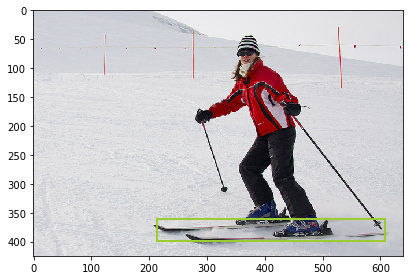

In [150]:
from skimage import io
import numpy as np
k=94
coco=COCO('../../../datasets/coco/annotations/instances_val2017.json')

id=cc_res[k]['image_id']
bounding_box=np.array([cc_res[k]['bbox']])
imgIds = coco.getImgIds(imgIds = [id])
img = coco.loadImgs(imgIds)[0]
I = io.imread(img['coco_url'])
# io.imshow(I)
io.imshow(draw_rect(I,bounding_box))


In [119]:
bounding_box=np.array([cc_res[k]['bbox']])
print(bounding_box.shape)
for cord in bounding_box:
    print(cord)

(1, 4)
[303.29138184 216.41239929  51.03204346  78.86180115]


In [125]:
import cv2
def draw_rect(im, cords, color = None):
  
    im = im.copy()
    if not color:
        color = (154,205,50)
    for cord in cords:
        pt1, pt2 = (cord[0], cord[1]) , (cord[2]+cord[0], cord[3]+cord[1])
        
        pt1 = int(pt1[0]), int(pt1[1])
        pt2 = int(pt2[0]), int(pt2[1])
        
        im = cv2.rectangle(im.copy(), pt1, pt2, color, 2)
    return im

In [112]:
io.imshow(draw_rect(I,bounding_box))

IndexError: index 1 is out of bounds for axis 0 with size 1

In [49]:
k=1
box_attr=pred_final[k]
xmin=box_attr[:,0]/inp_dim * targets[k]['img_size'][1]
ymin=box_attr[:,1]/inp_dim * targets[k]['img_size'][0]
xmax=box_attr[:,2]/inp_dim * targets[k]['img_size'][1]
ymax=box_attr[:,3]/inp_dim * targets[k]['img_size'][0]

0.5
tensor([[  3.6366, 163.6588,  98.9673, 255.9499],
        [284.8031, 163.2458, 304.5559, 295.5597],
        [372.5377, 212.1779, 417.8232, 278.3851],
        [189.1306, 215.9701, 223.4120, 306.4608],
        [194.3501, 215.5452, 229.3885, 308.0600],
        [233.6056, 216.0504, 265.5062, 308.5837],
        [248.9394, 217.1792, 282.5620, 302.7053],
        [358.7329, 294.3815, 380.4102, 392.2944],
        [367.1979, 210.0602, 417.2445, 278.4356],
        [268.2036, 153.3281, 301.6162, 285.2375],
        [269.0005, 160.4503, 301.6859, 297.2227],
        [363.7664, 206.3309, 417.5878, 287.4888],
        [187.1316, 214.6399, 226.5885, 311.0070],
        [189.0628, 212.4594, 233.7171, 311.7639],
        [228.0416, 212.2645, 273.8707, 309.9084],
        [239.0730, 213.7096, 284.3803, 309.2065],
        [290.3692, 117.0838, 300.4048, 137.5092],
        [247.0331, 168.7083, 262.6033, 208.5239],
        [108.5874, 228.7670, 121.3902, 260.9979]], device='cuda:0')


(416, 416, 3)


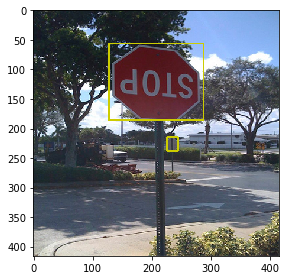

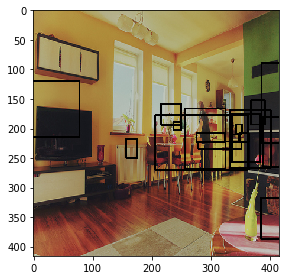

In [28]:
io.imshow(im)

In [1]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
cocoGt=COCO('../../../datasets/coco/annotations/instances_val2017.json')

resFile='./cc_bbox_results.json'
cocoDt=cocoGt.loadRes(resFile)
imgIds=sorted(cocoGt.getImgIds())
cocoDt.loadAnns()


# running evaluation
cocoEval = COCOeval(cocoGt,cocoDt,'bbox')
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

loading annotations into memory...
Done (t=0.63s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.85s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=32.30s).
Accumulating evaluation results...
DONE (t=2.54s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.019
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.027
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.022
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.016
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.040
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.022
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.022
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

In [58]:
ome,axis=1)
print(predictions.shape)

torch.Size([8, 255, 13, 13])
torch.Size([8, 10647, 85])


In [1]:
import pandas as pd
import matplotlib.pyplot as plt


bede=pd.read_csv('./benchmark_res_vis_bede.csv')
barkla=pd.read_csv('./benchmark_res_vis_barkla.csv')

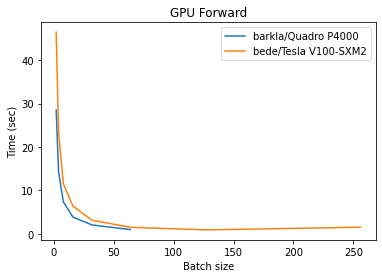

In [19]:
x_axis=bede['batch']
gpu_barkla=barkla['forw_time']
gpu_bede=bede['forw_time']
plt.plot(barkla['batch'], gpu_barkla, label = "barkla/Quadro P4000")
plt.plot(bede['batch'], gpu_bede,label = "bede/Tesla V100-SXM2")
plt.title('GPU Forward')
plt.xlabel('Batch size')
plt.ylabel('Time (sec)')
plt.legend()
plt.savefig('gpu_vis.png')
plt.show()


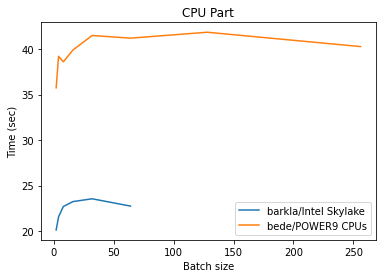

In [20]:
x_axis=bede['batch']
plt.plot(barkla['batch'], barkla['cpu_time'], label = "barkla/Intel Skylake")
plt.plot(bede['batch'], bede['cpu_time'],label = "bede/POWER9 CPUs")
plt.title('CPU Part')
plt.xlabel('Batch size')
plt.ylabel('Time (sec)')
plt.legend()
plt.savefig('cpu_vis.png')
plt.show()

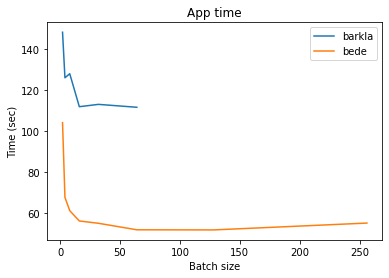

In [21]:
x_axis=bede['batch']
plt.plot(barkla['batch'], barkla['app_time'], label = "barkla")
plt.plot(bede['batch'], bede['app_time'],label = "bede")
plt.title('App time')
plt.xlabel('Batch size')
plt.ylabel('Time (sec)')
plt.legend()
plt.savefig('app_vis.png')
plt.show()

In [24]:
bede=pd.read_csv('./benchmark_res_node_bede.csv')
barkla=pd.read_csv('./benchmark_res_node_barkla.csv')

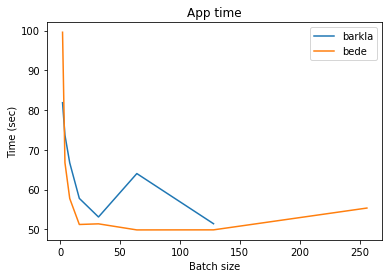

In [25]:
x_axis=bede['batch']
plt.plot(barkla['batch'], barkla['app_time'], label = "barkla")
plt.plot(bede['batch'], bede['app_time'],label = "bede")
plt.title('App time')
plt.xlabel('Batch size')
plt.ylabel('Time (sec)')
plt.legend()
plt.savefig('app_node.png')
plt.show()

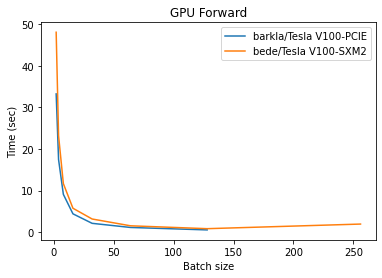

In [26]:
x_axis=bede['batch']
gpu_barkla=barkla['forw_time']
gpu_bede=bede['forw_time']
plt.plot(barkla['batch'], gpu_barkla, label = "barkla/Tesla V100-PCIE")
plt.plot(bede['batch'], gpu_bede,label = "bede/Tesla V100-SXM2")
plt.title('GPU Forward')
plt.xlabel('Batch size')
plt.ylabel('Time (sec)')
plt.legend()
plt.savefig('gpu_node.png')
plt.show()


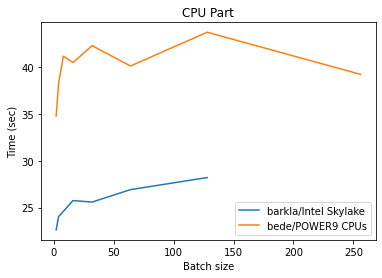

In [27]:
x_axis=bede['batch']
plt.plot(barkla['batch'], barkla['cpu_time'], label = "barkla/Intel Skylake")
plt.plot(bede['batch'], bede['cpu_time'],label = "bede/POWER9 CPUs")
plt.title('CPU Part')
plt.xlabel('Batch size')
plt.ylabel('Time (sec)')
plt.legend()
plt.savefig('cpu_node.png')
plt.show()

In [ ]:
np.array(barkla['map'])-np.array(bede['map'])